In [1]:
import numpy as np
import pandas as pd
import time
import mt_utils as ut
import parameter_utils as pu
import importlib
from tqdm import tqdm
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

In [2]:
importlib.reload(ut)

<module 'mt_utils' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\mt_utils.py'>

In [3]:
importlib.reload(pu)

<module 'parameter_utils' from 'E:\\Melli\\HU\\Masterarbeit Save\\Implementation\\parameter_utils.py'>

In [4]:
#import claspy
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.tests.evaluation import covering
from claspy.data_loader import load_tssb_dataset
from claspy.data_loader import load_has_dataset

In [14]:
tssb = load_tssb_dataset()
hasc = load_has_dataset()

# Functions

In [5]:
algos_sorted = ['None', "EveryNth","MinMax","M4","LTTB","MinMaxLTTB","LTD"]
algos_sorted_dsOnly = ["EveryNth","MinMax","M4","LTTB","MinMaxLTTB","LTD"]
columns = ['Algorithm', 'compression', 'window_size', 'orig_TS_ID', 'TS_Length', 'Time_Series', 'True_CPS', 'predicted_cps', 'score', 
           'runtime_getCR', 'runtime_downsample', 'runtime_clasp', 'runtime_upscale' ]

In [6]:
# please consult the master thesis pdf for a derivation of the window size thresholds
threshold_tssb = [25,False]
threshold_hasc = [40,True]

In [7]:
def critical_distance(df, title=None, filepath=None):
    avg_rank = df.groupby('orig_TS_ID').score.rank(pct=False, ascending=False).groupby(df.Algorithm).mean()
    p_vals = sp.posthoc_nemenyi_friedman(
        df,
        melted=True,
        block_col='orig_TS_ID',
        group_col='Algorithm',
        y_col='score',
    )

    fig = plt.figure(figsize=(10, 2), dpi=100)
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = "12"
    font = {'family':'arial','color':'black','size':12}
    plt.title(title, loc = 'left', fontdict=font, y=1.2)
    
    sp.critical_difference_diagram(avg_rank, p_vals,
                               label_props={'color': 'black'},
                               elbow_props={'color': 'gray'}                              
                              )
    
    if filepath:
         fig.savefig(filepath, bbox_inches='tight')

    plt.show()

In [8]:
# box plot
def boxplot_scores(df, title, filepath):
    fig = go.Figure()
    for i, algo in enumerate(algos_sorted):
        fig.add_trace(go.Box(
                            y=df['score'][df['Algorithm']==algo], 
                            name=algo,
                            boxmean='sd', 
                            marker_color='black',
                            line=dict(width=1),
                            fillcolor='rgba(0,0,0,0)'
                            )
                     )
        
    fig.update_layout(height=300, 
                      font=dict(
                          family="Arial",
                          size=12,
                          color="black"
                      ),
                      title=dict(
                          text=title
                      ),
                      margin=dict(l=0, r=0, t=30, b=0),
                      yaxis_title = 'Covering Score',
                      showlegend=False
                     )
    
    if filepath:
        fig.write_image(filepath, scale=1, width=1000, height=300)
    
    fig.show()

In [9]:
# summary statistics
def score_comparison_matrix_w(df, savepath):
    mean = df.groupby(by=['Algorithm']).mean().rename(columns={'score': 'mean'})
    median = df.groupby(by=['Algorithm']).median().rename(columns={'score': 'median'})
    std = df.groupby(by=['Algorithm']).std().rename(columns={'score': 'std'})
    
    out = mean.merge(median, left_on='Algorithm', right_on='Algorithm')
    out = out.merge(std, left_on='Algorithm', right_on='Algorithm')
    out = out.transpose()
    if(savepath):
        out.to_excel(savepath)
    return out[algos_sorted]

In [10]:
def downsample_and_segment(ts, change_points, algo, threshold, downscale_w=False):
    runtime_cr = time.process_time()
    # set compression ratio
    if algo == 'LTD':
        cr = 0.5
    else:
        if threshold[1]:
            cr = pu.find_cr_based_on_w_ubound(ts, threshold[0], downscale_w, algo)
        else:
            cr = pu.find_cr_based_on_w(ts, threshold[0], downscale_w, algo)
    runtime_cr = time.process_time() - runtime_cr

    runtime_ds = time.process_time()
    # downsample time series  
    n_out = ut.adjust_nout(algo, int(cr*ts.shape[0]))
    ds_ts_index = ut.downsample_multivariate(algo, ts, n_out)
    if ts.ndim == 1:
        ds_ts = ts[ds_ts_index]
    else:
        ds_ts = ut.get_ds_ts_ndim(ts, ds_ts_index)
    runtime_ds = time.process_time() - runtime_ds

    runtime_clasp = time.process_time()
    # instantiate clasp
    if downscale_w:
        window_size = int(pu.get_window_size_multivariate(ts)*cr)
        clasp = BinaryClaSPSegmentation(window_size)
    else:
        clasp = BinaryClaSPSegmentation()
        
    predictions = clasp.fit_predict(ds_ts)
    runtime_clasp = time.process_time() - runtime_clasp

    runtime_us = time.process_time()
    upscaled_predictions = pu.upscale_cps_linear(predictions, cr)
    runtime_us = time.process_time() - runtime_us
    
    score = covering({0: change_points}, upscaled_predictions, ts.shape[0])
    runtimes = [np.round(runtime_cr, 3), np.round(runtime_ds, 3), np.round(runtime_clasp, 3), np.round(runtime_us, 3)]
    
    return ds_ts, cr, clasp.window_size, upscaled_predictions, np.round(score, 3), runtimes

In [11]:
def main(dataset, threshold, downscale_w=False):
    import warnings
    warnings.simplefilter("ignore")
    results = []
    for index, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Processing rows"):
        ts_length = row.time_series.shape[0]
        window_size, predictions, score, runtime = ut.evaluate_clasp(row.time_series, row.cps)            
        results.append(('None', 1, window_size, index, ts_length, row.time_series, row.cps, predictions, score, 0,0,runtime,0))
        for algo in algos_sorted_dsOnly:
            downsampled_ts, compression, window_size, predictions, score, runtimes = downsample_and_segment(
                row.time_series, row.cps, algo, threshold, downscale_w
            )
            results.append((algo, compression, window_size, index, ts_length, downsampled_ts, row.cps, predictions, score, 
                            runtimes[0], runtimes[1], runtimes[2], runtimes[3]))
    return pd.DataFrame(results, columns=columns)    

In [12]:
def sum_up_runtimes(row):
    return row.runtime_getCR+row.runtime_downsample+row.runtime_clasp+row.runtime_upscale

def add_dataset_name_tssb(row):
    return tssb.iloc[row.orig_TS_ID].dataset

def add_dataset_name_hasc(row):
    return hasc.iloc[row.orig_TS_ID].dataset

In [13]:
def plot_runtimes_per_column(df, column, x_settings, title, filepath=None):
    df=df.sort_values('TS_Length')
    fig = go.Figure()
    for algo in algos_sorted:
        curr_df = df[df.Algorithm==algo]
        fig.add_trace(go.Scatter(x=curr_df[column], y=curr_df.runtime,
                        mode='lines',
                        name=algo))
        
    fig.update_yaxes(title_text="Runtime in Seconds")
    
    fig.update_layout(height=370,
                      font=dict(
                          family="Arial",
                          size=12,
                          color="black"
                      ),
                      title=dict(
                          text=title
                      ),
                      legend=dict(
                          yanchor="top",
                          y=0.98,
                          xanchor="left", 
                          x=0.01
                      ),
                      xaxis=x_settings,
                      margin=dict(l=0, r=0, t=30, b=0)
                     )
    if filepath:
        fig.write_image(filepath, scale=1, width=1000, height=370)

    fig.show()

# Covering Score

## TSSB

In [15]:
main_exp_tssb = main(tssb,threshold_tssb,False)

In [ ]:
main_exp_tssb.to_pickle('results/zwischenergebnisse/main_experiment_tssb.pkl')

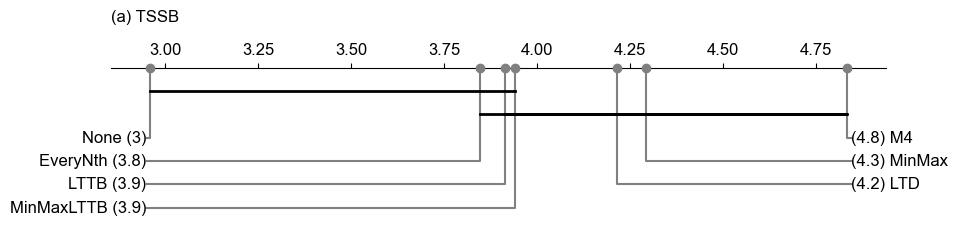

In [16]:
critical_distance(main_exp_tssb, title='(a) TSSB', filepath='results/figures/critical_distance_orig_scores_TSSB.svg')

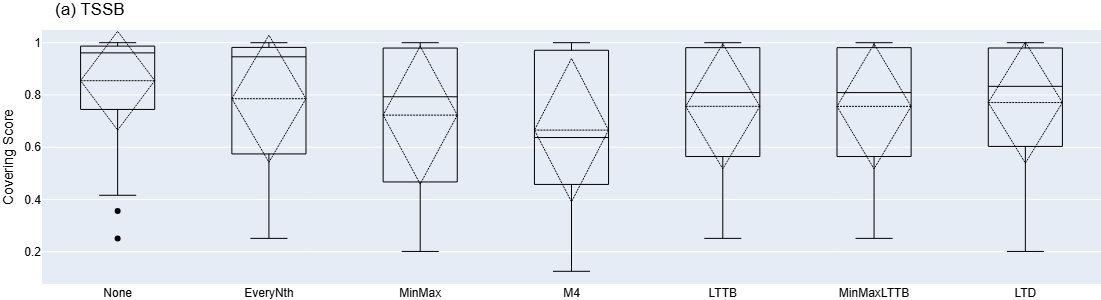

In [17]:
boxplot_scores(main_exp_tssb, '(a) TSSB', filepath='results/figures/boxplot_mainexp_scores_TSSB.svg')

In [18]:
score_comparison_matrix_w(main_exp_tssb[['Algorithm','score']], savepath='results/tables/summary_statistics_mainexp_TSSB.xlsx')

Algorithm,None,EveryNth,MinMax,M4,LTTB,MinMaxLTTB,LTD
mean,0.854547,0.785667,0.722800,0.665400,0.756467,0.756307,0.770907
median,0.961000,0.946000,0.793000,0.637000,0.809000,0.809000,0.833000
std,0.190514,0.245017,0.265686,0.276243,0.240966,0.240935,0.233486


## HASC

In [19]:
main_exp_hasc = main(hasc,threshold_hasc,True)

In [ ]:
main_exp_hasc.to_pickle('results/zwischenergebnisse/main_experiment_hasc.pkl')

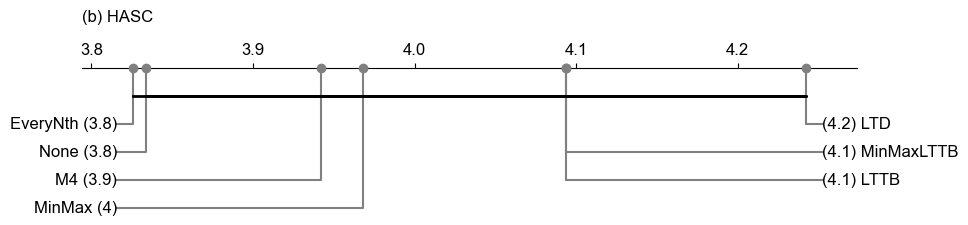

In [20]:
critical_distance(main_exp_hasc, title='(b) HASC', filepath='results/figures/critical_distance_orig_scores_HASC.svg')

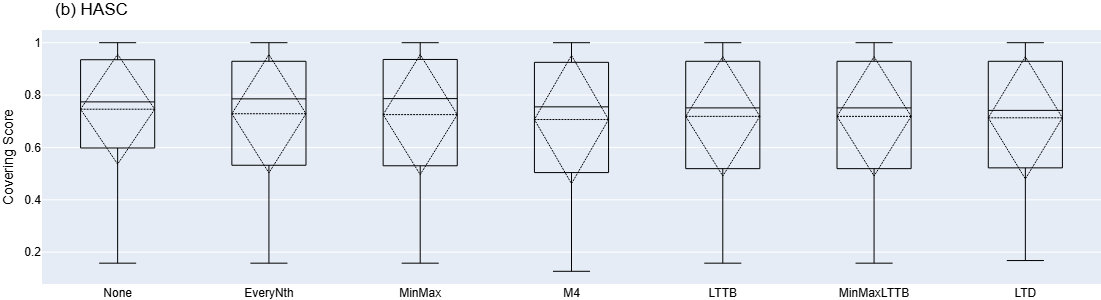

In [21]:
boxplot_scores(main_exp_hasc, '(b) HASC', filepath='results/figures/boxplot_mainexp_scores_HASC.svg')

In [22]:
score_comparison_matrix_w(main_exp_hasc[['Algorithm','score']], savepath='results/tables/summary_statistics_mainexp_HASC.xlsx')

Algorithm,None,EveryNth,MinMax,M4,LTTB,MinMaxLTTB,LTD
mean,0.746004,0.728780,0.725360,0.706644,0.718716,0.718716,0.713152
median,0.774000,0.785500,0.786500,0.755000,0.751000,0.751000,0.741500
std,0.210108,0.226451,0.229568,0.245386,0.228274,0.228274,0.233781


# Runtime

## TSSB

In [23]:
main_exp_tssb['runtime']=main_exp_tssb.apply(sum_up_runtimes, axis=1)
main_exp_tssb['dataset']=main_exp_tssb.apply(add_dataset_name_tssb, axis=1)

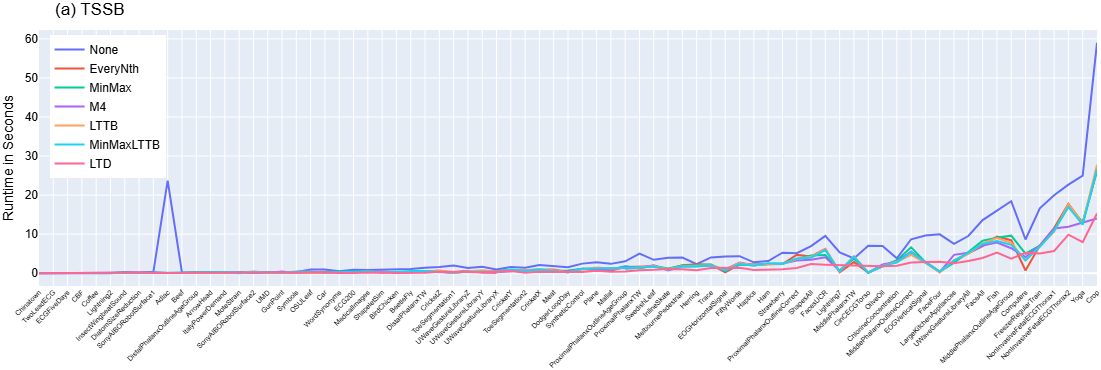

In [24]:
plot_runtimes_per_column(main_exp_tssb, 'dataset', dict(
                          tickangle=-45,
                          tickfont=dict(
                          size=7
                      )
                      ), '(a) TSSB', 'results/figures/runtimes_per_algo_tssb.png')

## HASC

In [25]:
main_exp_hasc['runtime']=main_exp_hasc.apply(sum_up_runtimes, axis=1)
main_exp_hasc['dataset']=main_exp_hasc.apply(add_dataset_name_hasc, axis=1)

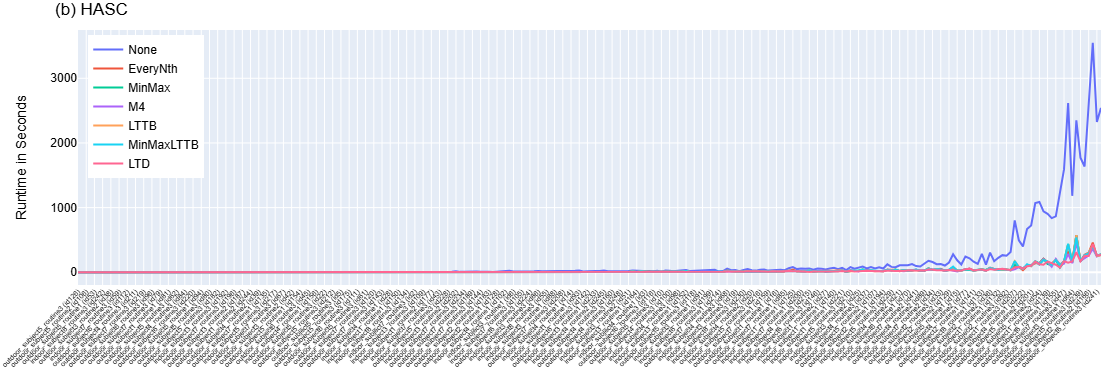

In [26]:
plot_runtimes_per_column(main_exp_hasc, 'dataset', dict(
                          tickangle=-45,
                          tickfont=dict(
                          size=7
                      )
                      ), '(b) HASC', 'results/figures/runtimes_per_algo_hasc.png')